# 1. Scrapping

In [438]:
from bs4 import BeautifulSoup
from pathlib import Path
import requests
import re

def get_text_auto(file_or_url):
  # Cek apakah input merupakan sebuah file
  if Path(file_or_url).is_file(): is_file = True
  else: is_file = False

  # Bila berupa file
  if is_file:
    # Cek tipe/ekstensi file
    file_ext = Path(file_or_url).suffix

    # Bila tipe file didukung
    if file_ext in ('.txt', '.html'):
      # Baca isi dari file sebagai plain teks
      file = open(file_or_url, 'r')
      text_content = file.read()
      file.close()

      # Parse HTML dahulu bila bukan plain teks
      if file_ext == '.html':
        text_content = get_text_from_url(text_content, True)
    # Bila tipe file tidak didukung
    else:
      print('Format file tidak didukung!')
      text_content = ''
  # Bila berupa URL
  else:
    text_content = get_text_from_url(file_or_url)

  # Berikan isi teks dari file atau URL
  return text_content

def get_text_from_url(url_content, from_file = False):
  if not from_file:
    try:
      # Dapatkan konten HTML dari URL
      url_content = requests.get(url_content, headers = {
        'User-Agent': 'Mozilla/5.0 (Linux; Android 13) Chrome/107.0',
        'Save-Data': 'on'
      }).content
    except: return ''
  else:
    # Data sudah dalam bentuk HTML
    pass

  # Objek bantuan untuk fungsi filter tag HTML dll
  soup = BeautifulSoup(url_content, 'html.parser')
  
  # Teks sampah pada beberapa situs (detik.com, liputan6.com, dll)
  # TODO: Gunakan filter adblock sebagai alternatif
  text_noise = (
    'ADVERTISEMENT',
    'SCROLL TO RESUME CONTENT',
    'SCROLL TO CONTINUE WITH CONTENT',
    'Advertisement',
    'liputan6'
  )
  strong_text_noise = (
    'lihat',
    'simak',
    'baca',
    'tonton',
    '(',
    '[',
    '*'
  )

  try:
    # Hilangkan informasi nama situs, tanggal, dan penulis dari liputan6.com
    soup.find('div', class_='read-page--header--author__wrapper').decompose()
    soup.find('div', class_='navbar--top--logo__site-title').decompose()
  except AttributeError: pass

  def text_scraping(soup, text_tag, tag_class = None):
    # Isi teks mula-mula (kosong)
    text_content = ''

    for paragraph in soup.find_all(text_tag, class_ = tag_class):
      # Hapus superscript (referensi Wikipedia) dari teks
      for p in paragraph.select('sup'): p.extract()
      # Hapus teks promosi dari beberapa situs (detik.com, liputan6.com, dll)
      for p in paragraph.select('strong'):
        temp_text = p.get_text().lower().strip()
        if temp_text.startswith(strong_text_noise): p.extract()
      # Hapus whitespace sesudah dan sebelum teks
      temp_text = paragraph.get_text().strip()
      # Filter kata sampah (bukan stop word)
      if temp_text not in text_noise:
        text_content += temp_text + ' '
      
    return text_content

  text_content = text_scraping(soup, 'p').strip()
  # Jika tag tidak menggunakan <p> (pada beberapa berita liputan6.com)
  if not text_content:
    text_content = text_scraping(soup, 'div', 'article-content-body__item-page').strip()

  # Hilangkan spasi beruntun dan baris baru
  text_content = re.sub('\s+', ' ', text_content)
  
  # Berikan isi teks
  return text_content

In [440]:
# file_or_url = 'example/text_original.txt'
file_or_url = 'https://www.liputan6.com/news/read/5/puluhan-agen-judi-digerebek-polisi'
# file_or_url = 'https://finance.detik.com/infografis/d-6412382/buruh-tolak-ump-2023-mengacu-pp-362021-ancam-aksi-besar-besaran'
# file_or_url = 'https://news.detik.com/berita/d-6411924/2-perusahaan-tersangka-kasus-gagal-ginjal-akut-terancam-15-dan-10-tahun-bui'
# file_or_url = 'https://inet.detik.com/science/d-6412223/meteorit-langka-yang-jatuh-tahun-lalu-ungkap-asal-air-di-bumi'
# file_or_url = 'https://www.detik.com/bali/berita/d-6412272/sandiaga-desak-hari-ekonomi-kreatif-nasional-segera-disahkan'

doc = get_text_auto(file_or_url)
print(doc)

# 2. Text Preprocessing

## 2.2. Sentence Segmentation

In [400]:
from spacy.lang.id import Indonesian
from spacy.symbols import ORTH

def sentence_segmentation(text):
  nlp = Indonesian()
  nlp.add_pipe('sentencizer')

  # Jangan anggap kasus berikut sebagai akhir kalimat
  nlp.tokenizer.add_special_case("Ir.", [{ORTH: "Ir."}])
  nlp.tokenizer.add_special_case("Mr.", [{ORTH: "Mr."}])
  nlp.tokenizer.add_special_case("PT.", [{ORTH: "PT."}])

  # Muat teks ke dalam pipeline
  doc = nlp(text)

  # Simpan hasil tokenisasi kalimat ke dalam list kalimat
  sentence_list = [ str(sentence) for sentence in doc.sents ]

  # Workaround kesalahan pengutipan pada tokenizer Indonesia
  for i, sentence in enumerate(sentence_list):
    # Kalimat diakhiri dengan titik dan kutip
    if sentence.endswith('. "'):
      sentence_list[i] = sentence_list[i][:-2]
      sentence_list[i+1] = '"' + sentence_list[i+1]
    # Kalimat diakhiri dengan titik, kutip, dan kurung
    elif sentence.endswith('. "('):
      sentence_list[i] = sentence_list[i][:-3]
      sentence_list[i+1] = '"(' + sentence_list[i+1]
  
  return sentence_list

In [401]:
sentence_list = sentence_segmentation(doc)

for i, sentence in enumerate(sentence_list):
    print(f'[{i+1}] {sentence}')

[1] Liputan6.com, Jakarta: Kepolisian Resor Kota Pekanbaru terus menggelar operasi pemberantasan perjudian.
[2] Hal itu dilakukan guna merespon aspirasi kelompok masyarakat dan mahasiswa terhadap maraknya perjudian di Kota Pekanbaru.
[3] Dalam operasinya, Jumat (13/10) malam, polisi berhasil menangkap sedikitnya 75 agen kupon Kim dan Sie jie di sejumlah jalan dan gang di Kota Pekanbaru.
[4] Jalan-jalan itu selama ini dikenal sebagai basis penjualan kupon judi.
[5] Alhasil, selain menangkap agen, polisi juga berhasil menyita sejumlah barang bukti.
[6] Saat dimintai keterangan, agen judi itu menolak untuk menyebutkan bandar utama judi tersebut.
[7] Kendati demikian, Kepala Polresta Pekanbaru Superintendent Didik T Prijandono menyatakan, ia telah mengetahui jaringan mata rantai perjudian tersebut.
[8] Sementara itu, beberapa waktu silam, berbagai elemen masyarakat Riau menggelar aksi unjuk rasa menolak peredaran judi dan narkotika dan obat-obat berbahaya.
[9] Sayangnya, aksi tersebut bera

### 2.2.1. Regex Cleaning

In [402]:
import re
import unicodedata

def sentence_clean_regex(sentence_list):
  for i, sentence in enumerate(sentence_list):
    # Hilangkan semua karakter non-ASCII (UNICODE, dll)
    # sentence = re.sub(r'[^\x00-\x7f]','', sentence)
    # sentence = sentence.encode('ascii', 'ignore').decode()
    sentence = unicodedata.normalize('NFKC', sentence)

    # Hilangkan URL
    sentence = re.sub(r'http[s]?://\S+', '', sentence)
    # Hilangkan tag/mention
    sentence = re.sub(r'@\S+', '', sentence)
    # Hilangkan hashtag
    sentence = re.sub(r'#\S+', '', sentence)

    # Ubah semua tab dan baris baru menjadi spasi
    sentence = re.sub(r'\t|\n|\r', ' ', sentence)

    # Hilangkan semua kata yang hanya terdiri dari non-alphabet
    # https://stackoverflow.com/questions/72318334
    sentence = re.sub(r'(?<!\S)[^A-Za-z]+(?!\S)', '', sentence)

    # Hilangkan semua karakter spesial yang tidak berada di antara alphanumerik
    # https://stackoverflow.com/questions/61049643
    sentence = re.sub(r'(?<!\w)\W+|\W+(?!\w)', ' ', sentence)

    # Hilangkan whitespace beruntun (lebih dari satu)
    sentence = re.sub(r'\s\s+', ' ', sentence)

    # Hilangkan trailing/leading whitespace
    sentence = sentence.strip()

    # Ganti isi kalimat saat ini dengan isi variabel sementara
    sentence_list[i] = sentence
  
  return sentence_list

In [403]:
from copy import deepcopy

# Salin list kalimat ke dalam variabel baru
sentence_list_regex = deepcopy(sentence_list)

# Hilangkan kata yang sesuai filter regex dari list kalimat
sentence_list_regex = sentence_clean_regex(sentence_list_regex)
for i, sentence in enumerate(sentence_list_regex):
    print(f'[{i+1}] {sentence}')

[1] Liputan6.com Jakarta Kepolisian Resor Kota Pekanbaru terus menggelar operasi pemberantasan perjudian
[2] Hal itu dilakukan guna merespon aspirasi kelompok masyarakat dan mahasiswa terhadap maraknya perjudian di Kota Pekanbaru
[3] Dalam operasinya Jumat malam polisi berhasil menangkap sedikitnya agen kupon Kim dan Sie jie di sejumlah jalan dan gang di Kota Pekanbaru
[4] Jalan-jalan itu selama ini dikenal sebagai basis penjualan kupon judi
[5] Alhasil selain menangkap agen polisi juga berhasil menyita sejumlah barang bukti
[6] Saat dimintai keterangan agen judi itu menolak untuk menyebutkan bandar utama judi tersebut
[7] Kendati demikian Kepala Polresta Pekanbaru Superintendent Didik T Prijandono menyatakan ia telah mengetahui jaringan mata rantai perjudian tersebut
[8] Sementara itu beberapa waktu silam berbagai elemen masyarakat Riau menggelar aksi unjuk rasa menolak peredaran judi dan narkotika dan obat-obat berbahaya
[9] Sayangnya aksi tersebut berakhir dengan bentrokan fisik
[10

### 2.2.2. Stopwords Removal

In [404]:
# Cek daftar kata dalam stopwords bawaan
# from spacy.lang.id.stop_words import STOP_WORDS

def sentence_stopwords_removal(sentence_list):
  nlp = Indonesian()
  # Tambah stopwords baru (bila ada)
  # nlp.Defaults.stop_words.add("kata_sampah")

  for i, sentence in enumerate(sentence_list):
    # Tokenisasi kalimat (menjadi per kata)
    tokens = nlp.tokenizer(sentence)
    # Kosongkan kalimat saat ini
    sentence_list[i] = ''
    # Tambah token ke kalimat bila bukan stopword
    # Sertakan juga pemisah antar kata (spasi)
    for token in tokens:
      if not token.is_stop:
        sentence_list[i] += token.text + token.whitespace_

  return sentence_list

In [405]:
from copy import deepcopy

# Salin list kalimat ke dalam variabel baru
sentence_list_nosw = deepcopy(sentence_list_regex)

# Hilangkan stopwords dari list kalimat
sentence_list_nosw = sentence_stopwords_removal(sentence_list_nosw)
for i, sentence in enumerate(sentence_list_nosw):
    print(f'[{i+1}] {sentence}')

[1] Liputan6.com Jakarta Kepolisian Resor Kota Pekanbaru menggelar operasi pemberantasan perjudian
[2] merespon aspirasi kelompok masyarakat mahasiswa maraknya perjudian Kota Pekanbaru
[3] operasinya Jumat malam polisi berhasil menangkap agen kupon Kim Sie jie jalan gang Kota Pekanbaru
[4] Jalan-jalan dikenal basis penjualan kupon judi
[5] Alhasil menangkap agen polisi berhasil menyita barang bukti
[6] keterangan agen judi menolak bandar utama judi 
[7] Kendati Kepala Polresta Pekanbaru Superintendent Didik T Prijandono jaringan mata rantai perjudian 
[8] silam elemen masyarakat Riau menggelar aksi unjuk menolak peredaran judi narkotika obat-obat berbahaya
[9] Sayangnya aksi bentrokan fisik
[10] Kepala Polda Riau berjanji menggelar operasi memerangi perjudian narkoba kian marak meresahkan masyarakat AWD/Yusril Ardanis


### 2.2.3. Word Lemmatization

In [406]:
""" def sentence_lemmatization(sentence_list):
  nlp = Indonesian()
  # Lemmatizer butuh install package "spacy_lookups_data"
  # https://github.com/explosion/spacy-lookups-data/tree/master/spacy_lookups_data/data
  lemmatizer = nlp.add_pipe("lemmatizer", config = {"mode": "lookup"})
  # Muat daftar kata dari "spacy_lookups_data"
  nlp.initialize()

  for i, sentence in enumerate(sentence_list):
    # Tokenisasi kalimat (menjadi per kata)
    tokens = lemmatizer(nlp.tokenizer(sentence))
    # Kosongkan kalimat saat ini
    sentence_list[i] = ''
    # Tambah token ke kalimat dalam bentuk lemma (bila ada)
    # Sertakan juga pemisah antar kata (spasi)
    for token in tokens:
      if token.lemma_:
        sentence_list[i] += token.lemma_ + token.whitespace_
      else:
        sentence_list[i] += token.text + token.whitespace_
    
  return sentence_list """

' def sentence_lemmatization(sentence_list):\n  nlp = Indonesian()\n  # Lemmatizer butuh install package "spacy_lookups_data"\n  # https://github.com/explosion/spacy-lookups-data/tree/master/spacy_lookups_data/data\n  lemmatizer = nlp.add_pipe("lemmatizer", config = {"mode": "lookup"})\n  # Muat daftar kata dari "spacy_lookups_data"\n  nlp.initialize()\n\n  for i, sentence in enumerate(sentence_list):\n    # Tokenisasi kalimat (menjadi per kata)\n    tokens = lemmatizer(nlp.tokenizer(sentence))\n    # Kosongkan kalimat saat ini\n    sentence_list[i] = \'\'\n    # Tambah token ke kalimat dalam bentuk lemma (bila ada)\n    # Sertakan juga pemisah antar kata (spasi)\n    for token in tokens:\n      if token.lemma_:\n        sentence_list[i] += token.lemma_ + token.whitespace_\n      else:\n        sentence_list[i] += token.text + token.whitespace_\n    \n  return sentence_list '

In [407]:
""" # Salin list kalimat ke dalam variabel baru
sentence_list_lemma = deepcopy(sentence_list_nosw)

# Ubah kata menjadi kata dasar pada kumpulan kalimat
sentence_list_lemma = sentence_lemmatization(sentence_list_lemma)
for i, sentence in enumerate(sentence_list_lemma):
    print(f'[{i+1}] {sentence}') """

" # Salin list kalimat ke dalam variabel baru\nsentence_list_lemma = deepcopy(sentence_list_nosw)\n\n# Ubah kata menjadi kata dasar pada kumpulan kalimat\nsentence_list_lemma = sentence_lemmatization(sentence_list_lemma)\nfor i, sentence in enumerate(sentence_list_lemma):\n    print(f'[{i+1}] {sentence}') "

### 2.2.4. Word Stemming

In [408]:
# https://github.com/har07/PySastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def sentence_stemming(sentence_list):
  stemmer = StemmerFactory().create_stemmer()
  for i, sentence in enumerate(sentence_list):
    sentence_list[i] = stemmer.stem(sentence)
  
  return sentence_list

In [409]:
# Salin list kalimat ke dalam variabel baru
# sentence_list_stem = deepcopy(sentence_list_lemma)
sentence_list_stem = deepcopy(sentence_list_nosw)

# Hilangkan imbuhan kata pada kumpulan kalimat
sentence_list_stem = sentence_stemming(sentence_list_stem)
for i, sentence in enumerate(sentence_list_stem):
    print(f'[{i+1}] {sentence}')

[1] liputan6 com jakarta polisi resor kota pekanbaru gelar operasi berantas judi
[2] merespon aspirasi kelompok masyarakat mahasiswa marak judi kota pekanbaru
[3] operasi jumat malam polisi hasil tangkap agen kupon kim sie jie jalan gang kota pekanbaru
[4] jalan kenal basis jual kupon judi
[5] alhasil tangkap agen polisi hasil sita barang bukti
[6] terang agen judi tolak bandar utama judi
[7] kendati kepala polresta pekanbaru superintendent didik t prijandono jaring mata rantai judi
[8] silam elemen masyarakat riau gelar aksi unjuk tolak edar judi narkotika obat bahaya
[9] sayang aksi bentrok fisik
[10] kepala polda riau janji gelar operasi rang judi narkoba kian marak resah masyarakat awd yusril ardanis


In [410]:
def sentence_preprocess(text_content):
    sentence_list = sentence_segmentation(text_content)
    sentence_list = sentence_clean_regex(sentence_list)
    sentence_list = sentence_stopwords_removal(sentence_list)
    sentence_list = sentence_stemming(sentence_list)

    return sentence_list

## 2.3. Word Tokenization
Word tokenization tidak dibutuhkan karena proses TF-IDF akan menggunakan string kalimat secara langsung

In [411]:
""" from spacy.tokenizer import Tokenizer

def word_tokenization(sentence_list):
  nlp = Indonesian()
  tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\w+').match)

  # Buat list kalimat yang dipecah per kata
  sentence_list_new = []

  for sentence in sentence_list:
    word_list = []
    tokens = tokenizer(str(sentence))
    for token in tokens:
        word_list.append(token)
    sentence_list_new.append(word_list)
  
  # Kembalikan list kalimat yang telah dipecah per kata
  return sentence_list_new """

" from spacy.tokenizer import Tokenizer\n\ndef word_tokenization(sentence_list):\n  nlp = Indonesian()\n  tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\\w+').match)\n\n  # Buat list kalimat yang dipecah per kata\n  sentence_list_new = []\n\n  for sentence in sentence_list:\n    word_list = []\n    tokens = tokenizer(str(sentence))\n    for token in tokens:\n        word_list.append(token)\n    sentence_list_new.append(word_list)\n  \n  # Kembalikan list kalimat yang telah dipecah per kata\n  return sentence_list_new "

In [412]:
""" # Salin list kalimat ke dalam variabel baru
sentence_list_word = deepcopy(sentence_list_stem)

# Ubah tiap kalimat menjadi list pecahan kata
sentence_list_word = word_tokenization(sentence_list_word)
for i, sentence in enumerate(sentence_list_word):
    print(f'[{i+1}] {sentence}') """

" # Salin list kalimat ke dalam variabel baru\nsentence_list_word = deepcopy(sentence_list_stem)\n\n# Ubah tiap kalimat menjadi list pecahan kata\nsentence_list_word = word_tokenization(sentence_list_word)\nfor i, sentence in enumerate(sentence_list_word):\n    print(f'[{i+1}] {sentence}') "

# 3. Text Processing

## 3.1. Weighting Word Frequency (TF-IDF)

In [413]:
print(sentence_list_stem)

['liputan6 com jakarta polisi resor kota pekanbaru gelar operasi berantas judi', 'merespon aspirasi kelompok masyarakat mahasiswa marak judi kota pekanbaru', 'operasi jumat malam polisi hasil tangkap agen kupon kim sie jie jalan gang kota pekanbaru', 'jalan kenal basis jual kupon judi', 'alhasil tangkap agen polisi hasil sita barang bukti', 'terang agen judi tolak bandar utama judi', 'kendati kepala polresta pekanbaru superintendent didik t prijandono jaring mata rantai judi', 'silam elemen masyarakat riau gelar aksi unjuk tolak edar judi narkotika obat bahaya', 'sayang aksi bentrok fisik', 'kepala polda riau janji gelar operasi rang judi narkoba kian marak resah masyarakat awd yusril ardanis']


In [414]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(sentence_list_stem)

# print(tfidf.idf_)

In [415]:
import pandas as pd

# Dapatkan vocabulary (list kata unik)
feature_names = tfidf.get_feature_names_out()

# Dapatkan list nama kalimat sebagai kolom
# sentence_index = [ sentence for sentence in sentence_list_stem ]

# Dapatkan list urutan kalimat sebagai kolom
sentence_index = [ f"S{i+1}" for i in range(len(sentence_list_stem)) ]

# Tampilkan hasil TF-IDF
# https://stackoverflow.com/questions/46597476
df = pd.DataFrame(data = tfs.todense(), index = sentence_index, columns = feature_names)
display(df)

,agen,aksi,alhasil,ardanis,aspirasi,awd,bahaya,bandar,barang,basis,...,sie,silam,sita,superintendent,tangkap,terang,tolak,unjuk,utama,yusril
S1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S2,0.000000,0.000000,0.000000,0.000000,0.392119,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S3,0.218930,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.294368,0.000000,0.000000,0.000000,0.250239,0.000000,0.000000,0.000000,0.000000,0.000000
S4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.462106,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S5,0.290564,0.000000,0.390685,0.000000,0.000000,0.000000,0.000000,0.000000,0.390685,0.000000,...,0.000000,0.000000,0.390685,0.000000,0.332118,0.000000,0.000000,0.000000,0.000000,0.000000
S6,0.325327,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.437426,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.437426,0.371852,0.000000,0.437426,0.000000
S7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.326208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S8,0.000000,0.262196,0.000000,0.000000,0.000000,0.000000,0.308433,0.000000,0.000000,0.000000,...,0.000000,0.308433,0.000000,0.000000,0.000000,0.000000,0.262196,0.308433,0.000000,0.000000
S9,0.000000,0.440595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S10,0.000000,0.000000,0.000000,0.276659,0.000000,0.276659,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.276659


## 3.2. K-Means Clustering

### 3.2.1. Elbow Method

In [416]:
max_clusters = 5

# Bila jumlah cluster melebihi jumlah kalimat
if max_clusters > tfs.shape[0]:
  max_clusters = tfs.shape[0] - 1

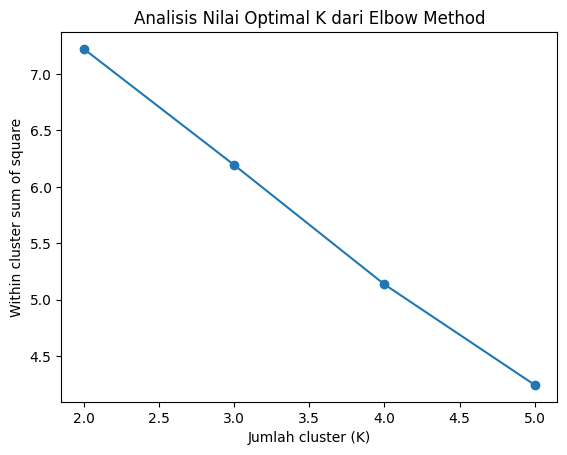

In [417]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

if max_clusters > 2:
  for i in range(2, max_clusters + 1):
    # Proses K-means berulang-ulang sampai jumlah kluster tertentu
    kmeans = KMeans(n_clusters = i, random_state = 66)
    # Prediksi kluster tiap kalimat pada dokumen
    kmeans.fit_predict(tfs)
    # Tambahkan WCSS untuk jumlah K saat ini
    wcss.append(kmeans.inertia_)
else:
  # Proses K-means hanya untuk K = 2 (paling minimum)
  kmeans = KMeans(n_clusters = 2, random_state = 66)
  # Prediksi kluster tiap kalimat pada dokumen
  kmeans.fit_predict(tfs)
  # Tambahkan WCSS untuk jumlah K saat ini
  wcss.append(kmeans.inertia_)

if max_clusters > 2:
  # Tampilkan plot analisis skor silhouette
  plt.plot([ i for i in range(2, max_clusters + 1) ], wcss, 'o-')
  plt.xlabel('Jumlah cluster (K)') 
  plt.ylabel('Within cluster sum of square') 
  plt.title('Analisis Nilai Optimal K dari Elbow Method')
  plt.show()

In [418]:
from kneed import KneeLocator
import warnings

# Tampilkan nilai WCSS
for i, s in enumerate(wcss):
  print(f'Nilai WCSS K = {i+2}: {s}')

# Hilangkan warning bila tidak terdapat siku/lutut
warnings.filterwarnings("ignore")

# Dapatkan indeks kluster yang terletak di siku/lutut
if max_clusters > 2:
  knee_cluster_index = KneeLocator(
    range(2, max_clusters + 1), wcss,
    curve = 'convex', direction = 'decreasing'
  ).knee
else:
  print("Tidak memungkinkan menggunakan jumlah K > 2...")
  knee_cluster_index = 2

# Jika tidak ditemukan siku/lutut
if knee_cluster_index == None:
  print('Siku/lutut tidak ditemukan! Set ke K = 2...')
  knee_cluster_index = 2

print(f'Siku/lutut terletak pada K = {knee_cluster_index}')

Nilai WCSS K = 2: 7.221960302456144
Nilai WCSS K = 3: 6.193703251875773
Nilai WCSS K = 4: 5.135279612950949
Nilai WCSS K = 5: 4.244467918890695
Siku/lutut tidak ditemukan! Set ke K = 2...
Siku/lutut terletak pada K = 2


In [419]:
# Jalankan kembali K-means dengan nilai K terbaik
kmeans = KMeans(knee_cluster_index, random_state = 66)
kmeans.fit_predict(tfs)

# Simpan atribut penting untuk kluster terbaik
elbow_cluster_label = kmeans.labels_
elbow_cluster_center = kmeans.cluster_centers_

In [420]:
print(elbow_cluster_label)

[0 0 1 0 1 0 0 0 0 0]


### 3.2.2. Silhouette Coefficient

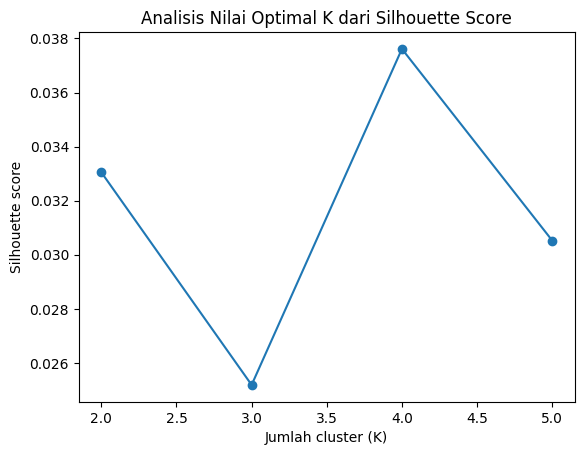

In [421]:
from sklearn.metrics import silhouette_score

silhouette_avg = []

if max_clusters > 2:
  for i in range(2, max_clusters + 1):
    # Proses K-means berulang-ulang sampai jumlah kluster tertentu
    kmeans = KMeans(n_clusters = i, random_state = 66)
    # Prediksi kluster tiap kalimat pada dokumen
    kmeans.fit_predict(tfs)
    # Hitung skor silhoutte untuk jumlah K saat ini
    silhouette_avg.append(
      silhouette_score(tfs, kmeans.labels_, metric = 'euclidean')
    )
    # Jika skor tertinggi, simpan beberapa atribut untuk digunakan nanti
    if silhouette_avg[-1] == max(silhouette_avg):
      silhouette_cluster_label = kmeans.labels_
      silhouette_cluster_center = kmeans.cluster_centers_
else:
  # Proses K-means hanya untuk K = 2 (paling minimum)
  kmeans = KMeans(n_clusters = 2, random_state = 66)
  # Prediksi kluster tiap kalimat pada dokumen
  kmeans.fit_predict(tfs)
  # Hitung skor silhoutte untuk jumlah K saat ini
  silhouette_avg.append(
    silhouette_score(tfs, kmeans.labels_, metric = 'euclidean')
  )
  # Simpan beberapa atribut untuk digunakan nanti
  silhouette_cluster_label = kmeans.labels_
  silhouette_cluster_center = kmeans.cluster_centers_

if max_clusters > 2:
  # Tampilkan plot analisis skor silhouette
  plt.plot([ i for i in range(2, max_clusters + 1) ], silhouette_avg, 'o-')
  plt.xlabel('Jumlah cluster (K)') 
  plt.ylabel('Silhouette score') 
  plt.title('Analisis Nilai Optimal K dari Silhouette Score')
  plt.show()

In [422]:
# Tampilkan nilai skor silhouette
for i, s in enumerate(silhouette_avg):
  print(f'Skor silhouette K = {i+2}: {s}')

print(f'Skor terbaik terletak pada K = {silhouette_avg.index(max(silhouette_avg))+2}')

Skor silhouette K = 2: 0.03304961833395119
Skor silhouette K = 3: 0.02518390013522101
Skor silhouette K = 4: 0.037613902584551065
Skor silhouette K = 5: 0.030523886377985837
Skor terbaik terletak pada K = 4


### 3.2.3. Silhouette Coefficient or Elbow Method?

In [423]:
# Jika memilih silhouette coefficient
# cluster_label = silhouette_cluster_label
# cluster_center = silhouette_cluster_center

# Jika memilih elbow method
cluster_label = elbow_cluster_label
cluster_center = elbow_cluster_center

# Tampilkan kluster tiap kalimat
for label in set(cluster_label):
  print(f'[Kluster {label}]')
  for i, sentence in enumerate(sentence_list):
    if cluster_label[i] == label:
      print(f'[{i+1}] {sentence}')
  print()

# print(cluster_label)

[Kluster 0]
[1] Liputan6.com, Jakarta: Kepolisian Resor Kota Pekanbaru terus menggelar operasi pemberantasan perjudian.
[2] Hal itu dilakukan guna merespon aspirasi kelompok masyarakat dan mahasiswa terhadap maraknya perjudian di Kota Pekanbaru.
[4] Jalan-jalan itu selama ini dikenal sebagai basis penjualan kupon judi.
[6] Saat dimintai keterangan, agen judi itu menolak untuk menyebutkan bandar utama judi tersebut.
[7] Kendati demikian, Kepala Polresta Pekanbaru Superintendent Didik T Prijandono menyatakan, ia telah mengetahui jaringan mata rantai perjudian tersebut.
[8] Sementara itu, beberapa waktu silam, berbagai elemen masyarakat Riau menggelar aksi unjuk rasa menolak peredaran judi dan narkotika dan obat-obat berbahaya.
[9] Sayangnya, aksi tersebut berakhir dengan bentrokan fisik.
[10] Saat ini, Kepala Polda Riau berjanji akan terus menggelar operasi guna memerangi perjudian dan narkoba, yang kian marak dan meresahkan masyarakat.(AWD/Yusril Ardanis)

[Kluster 1]
[3] Dalam operasin

In [424]:
for i, centroid in enumerate(cluster_center):
  print(f'Centroid {i+1}:', centroid.tolist(), end = '\n\n')

Centroid 1: [0.04066584137402167, 0.08784882563052474, 0.0, 0.034582436709970486, 0.049014850898918425, 0.034582436709970486, 0.038554089363976134, 0.05467826954993729, 0.0, 0.05776321058172574, 0.06478636292899256, 0.04450858586528603, 0.0, 0.04450858586528603, 0.040775937865540665, 0.038554089363976134, 0.038554089363976134, 0.06478636292899256, 0.0, 0.08749613877557952, 0.0, 0.04450858586528603, 0.04910400624014467, 0.034582436709970486, 0.040775937865540665, 0.0, 0.05776321058172574, 0.18258051320162866, 0.0, 0.049014850898918425, 0.05776321058172574, 0.040775937865540665, 0.06406150312866674, 0.034582436709970486, 0.0, 0.06955613766695815, 0.04910400624014467, 0.04450858586528603, 0.049014850898918425, 0.0, 0.07106533191395556, 0.09084758095828491, 0.040775937865540665, 0.049014850898918425, 0.034582436709970486, 0.038554089363976134, 0.038554089363976134, 0.05882232566297879, 0.08880261557005413, 0.034582436709970486, 0.033102347742126385, 0.040775937865540665, 0.0407759378655406

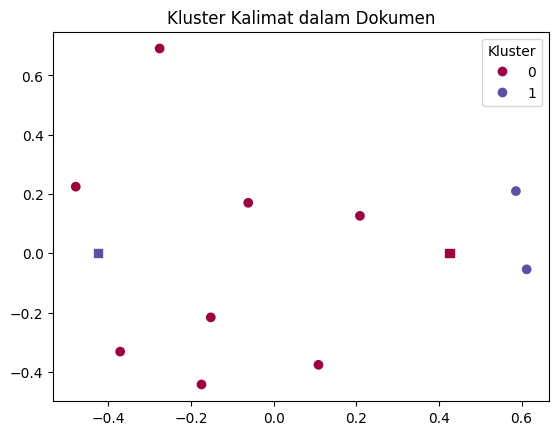

In [425]:
from sklearn.decomposition import PCA

# Gabungkan kolom frekuensi TF-IDF menjadi 2 dimensi saja
pca_tfs = PCA(n_components = 2).fit_transform(tfs.toarray())

# Gabungkan centroid kluster menjadi 2 dimensi saja
pca_cc = PCA(n_components = 2).fit_transform(cluster_center)

""" # Berikan warna secara dinamis untuk tiap kluster
colors = plt.cm.Spectral(np.linspace(0 , 1, len(set(cluster_label))))

# Tampilkan nomor kalimat dan warna kluster
for i in range(len(pca)):
  plt.plot(pca_tfs[i,0], pca_tfs[i,1], # marker = 'o',
      linestyle = '', c = colors[cluster_label[i]],
      markersize = 14, marker = f'${i+1}$'
  ) """

# Buat figur baru untuk visualisasi
fig, ax = plt.subplots()

# Tampilkan kalimat (tanpa penomoran) dan warna kluster
sc = ax.scatter(pca_tfs[:,0], pca_tfs[:,1], c = cluster_label, cmap = 'Spectral')
ax.legend(*sc.legend_elements(), title ='Kluster')

# Tampilkan centroid tiap kluster (kurang akurat karena pengurangan dimensi)
ax.scatter(pca_cc[:,0], pca_cc[:,1], marker = 's', label = 'Centroid',
  c = [ i for i in range(len(cluster_center)) ], cmap = 'Spectral'
)

# Tampilkan hasil visualisasi
plt.title("Kluster Kalimat dalam Dokumen")
plt.show()

In [426]:
# Dapatkan nilai rata-rata TF-IDF per kata dalam suatu kalimat
# Lalu, anggap nilai tersebut sebagai nilai TF-IDF kalimat
# Nilai nol pada list/array akan dihilangkan sebelum dirata-rata
sentence_relevancy = [ sum(t) / len(t) for t in tfs.toarray() ]

for i, r in enumerate(sentence_relevancy):
  print(f'Nilai TF-IDF (relevansi) S{i+1}: {r}')

Nilai TF-IDF (relevansi) S1: 0.047081598741705324
Nilai TF-IDF (relevansi) S2: 0.0425434023364137
Nilai TF-IDF (relevansi) S3: 0.05561632500445618
Nilai TF-IDF (relevansi) S4: 0.03474259010030001
Nilai TF-IDF (relevansi) S5: 0.040697185826924304
Nilai TF-IDF (relevansi) S6: 0.0353030725731042
Nilai TF-IDF (relevansi) S7: 0.047270677923830086
Nilai TF-IDF (relevansi) S8: 0.051518061845185724
Nilai TF-IDF (relevansi) S9: 0.028919816366069183
Nilai TF-IDF (relevansi) S10: 0.0572120666952435


In [427]:
# Nilai TF-IDF mula-mula tiap kluster adalah nol
cluster_relevancy = [ 0 for _ in set(cluster_label) ]

for i, label in enumerate(set(cluster_label)):
  temp_cluster_members = 0
  for j, sentence in enumerate(sentence_list):
    if cluster_label[j] == label:
      # Totalkan nilai TF-IDF per kalimat menjadi nilai TF-IDF kluster
      cluster_relevancy[i] += sentence_relevancy[j]
      # Hitung jumlah kalimat dalam kluster yang sama
      temp_cluster_members += 1
  # Rata-ratakan nilai TF-IDF kluster (dibagi dengan jumlah kalimat)
  # Untuk mengurangi skew ke kluster dengan kalimat panjang
  cluster_relevancy[i] /= temp_cluster_members

for i, r in enumerate(cluster_relevancy):
  print(f'Nilai TF-IDF (relevansi) K{i}: {r}')

Nilai TF-IDF (relevansi) K0: 0.04307391082273146
Nilai TF-IDF (relevansi) K1: 0.04815675541569024


## 3.3. Text Summarization Result

In [428]:
# Simpan nomor kluster yang paling relevan
most_relevant_cluster = cluster_relevancy.index(max(cluster_relevancy))
# Simpan jumlah kalimat dari kluster yang paling relevan
top_cluster_members = 0

# Set jumlah kalimat maksimal untuk hasil ringkasan
max_summary_sentences = 5

# Teks gabungan hasil summarization
kmeans_summarization = ""
tfidf_summarization = ""

# Tampilkan kluster paling baik
print(f'[K-means clustering]')
for i, sentence in enumerate(sentence_list):
  if top_cluster_members == max_summary_sentences: break
  if cluster_label[i] == most_relevant_cluster:
    kmeans_summarization += sentence
    print(f'[{i+1}] {sentence}')
    top_cluster_members += 1

# ====================

# Dapatkan indeks dari kalimat dengan TF-IDF tertinggi
# Jumlah kalimat mengikuti kluster terbaik dari K-means
top_n_sentences = sorted(
  range(len(sentence_relevancy)),
  key = lambda i: sentence_relevancy[i],
  reverse = True
)[:top_cluster_members]

# Bandingkan K-means dengan TF-IDF biasa
print(f'\n[TF-IDF biasa]')
for i, sentence in enumerate(sentence_list):
  if i in top_n_sentences:
    tfidf_summarization += sentence
    print(f'[{i+1}] {sentence}')

[K-means clustering]
[3] Dalam operasinya, Jumat (13/10) malam, polisi berhasil menangkap sedikitnya 75 agen kupon Kim dan Sie jie di sejumlah jalan dan gang di Kota Pekanbaru.
[5] Alhasil, selain menangkap agen, polisi juga berhasil menyita sejumlah barang bukti.

[TF-IDF biasa]
[3] Dalam operasinya, Jumat (13/10) malam, polisi berhasil menangkap sedikitnya 75 agen kupon Kim dan Sie jie di sejumlah jalan dan gang di Kota Pekanbaru.
[10] Saat ini, Kepala Polda Riau berjanji akan terus menggelar operasi guna memerangi perjudian dan narkoba, yang kian marak dan meresahkan masyarakat.(AWD/Yusril Ardanis)


In [429]:
print(f'Jumlah karakter teks awal: {len(doc)}')
print(f'Jumlah karakter teks K-means: {len(kmeans_summarization)}')
print(f'Jumlah karakter teks TF-IDF biasa: {len(tfidf_summarization)}')

# Tampilkan persentase pengurangan teks ringkasan dibanding teks asli
kmeans_char_diff = 100 - (len(kmeans_summarization) / len(doc) * 100)
print(f'Pengurangan teks pada K-means: {round(kmeans_char_diff)}%')
tfidf_char_diff = 100 - (len(tfidf_summarization) / len(doc) * 100)
print(f'Pengurangan teks pada TF-IDF biasa: {round(tfidf_char_diff)}%')

Jumlah karakter teks awal: 1159
Jumlah karakter teks K-means: 234
Jumlah karakter teks TF-IDF biasa: 317
Pengurangan teks pada K-means: 80%
Pengurangan teks pada TF-IDF biasa: 73%


In [430]:
print(kmeans_summarization)

Dalam operasinya, Jumat (13/10) malam, polisi berhasil menangkap sedikitnya 75 agen kupon Kim dan Sie jie di sejumlah jalan dan gang di Kota Pekanbaru.Alhasil, selain menangkap agen, polisi juga berhasil menyita sejumlah barang bukti.


# 4. Evaluation

## 4.1 Get Reference Summary

In [431]:
import json
import requests

def get_reference_summary(url, max_summary_sentences):
  # Hasil ringkasan mula-mula
  summary_sentence = ""

  # Jika situs berasal dari liputan6.com
  if url.startswith('https://www.liputan6.com/news/read/'):
    # Dapatkan ID berita dari URL
    news_id = url.split('/')[5]

    # Buka file JSON
    try:
      with open(f'./dataset/{news_id}.json') as json_file:
        data = json.load(json_file)

        for i, sentence in enumerate(data["clean_article"]):
          # Jika urutan kalimat saat ini merupakan ringkasan
          if i in data["extractive_summary"]:
            for word in sentence:
              if word.isalnum(): summary_sentence += ' ' + word
              else: summary_sentence += word
    except Exception: pass

  # Jika hasil kosong atau situs bukan berasal dari liputan6.com
  if not summary_sentence:
    api_url = "https://api.smmry.com"
    query_string = {
      # Request API key: https://smmry.com/api
      "SM_API_KEY": "XXXXXXXXXX",
      "SM_LENGTH": max_summary_sentences
    }

    if not Path(url).is_file():
      query_string["SM_URL"] = url
      response = requests.request("GET", api_url, params = query_string)
    else:
      form_data = { "sm_api_input": get_text_auto(url) }
      response = requests.request("POST", api_url, params = query_string, data = form_data)

    try: summary_sentence = response.json()["sm_api_content"]
    except Exception:
      print(f'Gagal mendapatkan ringkasan pembanding secara otomatis!')

  return summary_sentence.strip()

# Impor teks hasil ringkasan pembanding (ringkasan manusia lebih baik)
# human_summarization = get_text_auto('example/text_ref_summary.txt')
human_summarization = get_reference_summary(file_or_url, max_summary_sentences)

# Tampilkan hasil ringkasan pembanding
print(human_summarization)

Hal itu dilakukan guna merespon aspirasi kelompok masyarakat dan mahasiswa terhadap maraknya perjudian di Kota Pekanbaru. Alhasil, selain menangkap agen, polisi juga berhasil menyita sejumlah barang bukti.


## 4.2. ROUGE Metrics

In [432]:
""" def rouge_preprocess(text_summarization):
  # Ubah semua teks menjadi huruf kecil
  text_summarization = text_summarization.lower()
  # Ubah semua tab dan baris baru menjadi spasi
  text_summarization = re.sub(r'\t|\n|\r', ' ', text_summarization)
  # Normalisasi karakter non-ASCII
  text_summarization = unicodedata.normalize('NFKC', text_summarization)

  # Pecah teks menjadi kalimat
  rouge_sentence_list = sentence_segmentation(text_summarization)

  for i, sentence in enumerate(rouge_sentence_list):
    # Hilangkan semua karakter non-alphanumerik
    sentence = re.sub(r'[^a-zA-Z\d\s]+', ' ', sentence)
    # Hilangkan whitespace beruntun (lebih dari satu)
    sentence = re.sub(r'\s\s+', ' ', sentence)
    # Tambahkan kembali titik sebagai pemisah kalimat
    sentence += "."
    # Simpan kalimat yang telah dimodifikasi
    rouge_sentence_list[i] = sentence
  
  # Gabung semua kalimat dan kembalikan
  return ' '.join(rouge_sentence_list) """

# Backup ke variabel lain
kmeans_summarization_list = sentence_segmentation(kmeans_summarization)
tfidf_summarization_list = sentence_segmentation(tfidf_summarization)
human_summarization_list = sentence_segmentation(human_summarization)

# Lakukan preprocessing sebelum lanjut ke ROUGE
kmeans_summarization = sentence_preprocess(kmeans_summarization)
tfidf_summarization = sentence_preprocess(tfidf_summarization)
human_summarization = sentence_preprocess(human_summarization)

In [433]:
print(kmeans_summarization)

['operasi jumat malam polisi hasil tangkap agen kupon kim sie jie jalan gang kota pekanbaru', 'alhasil tangkap agen polisi hasil sita barang bukti']


In [434]:
print(human_summarization)

['merespon aspirasi kelompok masyarakat mahasiswa marak judi kota pekanbaru', 'alhasil tangkap agen polisi hasil sita barang bukti']


In [435]:
# https://github.com/pltrdy/rouge
from rouge import Rouge

def get_rouge_score(machine_summary, human_summary):
  # Sesuaikan banyak kalimat untuk dibandingkan (ambil yang paling sedikit)
  if (len(machine_summary) > len(human_summary)):
    machine_summary = machine_summary[:len(human_summary)]
    print(f'Hanya membandingkan {len(human_summary)} kalimat pertama...')
  elif (len(machine_summary) < len(human_summary)):
    human_summary = human_summary[:len(machine_summary)]
    print(f'Hanya membandingkan {len(machine_summary)} kalimat pertama...')
  else:
    print('Membandingkan seluruh kalimat...')

  machine_summary = '. '.join(machine_summary)
  human_summary = '. '.join(human_summary)

  # Hitung skor ROUGE antara teks ringkasan mesin dengan pembanding
  rouge = Rouge().get_scores(machine_summary, human_summary)[0]

  # Tampilkan hasilnya dalam bentuk recall, precision, dan skor F1
  for i, val in enumerate(rouge.values()):
    print(['ROUGE 1-gram','ROUGE 2-gram','ROUGE LCS'][i], end = ": ")
    print(f'{round(val["r"], 5)} (r), {round(val["p"], 5)} (p), {round(val["f"], 5)} (f)')

print('[Hasil ROUGE K-means]')
get_rouge_score(kmeans_summarization, human_summarization)

print('\n[Hasil ROUGE TF-IDF biasa]')
get_rouge_score(tfidf_summarization, human_summarization)

[Hasil ROUGE K-means]
Membandingkan seluruh kalimat...
ROUGE 1-gram: 0.58824 (r), 0.52632 (p), 0.55556 (f)
ROUGE 2-gram: 0.5625 (r), 0.45 (p), 0.5 (f)
ROUGE LCS: 0.58824 (r), 0.52632 (p), 0.55556 (f)

[Hasil ROUGE TF-IDF biasa]
Membandingkan seluruh kalimat...
ROUGE 1-gram: 0.52941 (r), 0.3 (p), 0.38298 (f)
ROUGE 2-gram: 0.1875 (r), 0.1 (p), 0.13043 (f)
ROUGE LCS: 0.29412 (r), 0.16667 (p), 0.21277 (f)


In [436]:
import csv

def import_file(document, human_summary, machine_summary, file_or_url = "", file_output = ""):
  # Path file output secara default
  if not file_output:
    file_output = "output/log.csv"

  # Jika file belum ada atau kosong
  if not Path(file_output).is_file() or Path(file_output).stat().st_size == 0:
    with open(file_output, 'w') as fw:
      writer = csv.writer(fw, delimiter = ';')
      # Buat header baru bila belum ada file
      writer.writerow(['file_or_url', 'full_document', 'human_summary', 'machine_summary'])
  
  with open(file_output, 'r+') as frw:
    reader = csv.reader(frw, delimiter = ';')
    # Simpan list baris yang tidak memiliki file/URL yang sama dengan parameter
    rows = [row for row in reader if row[0] != file_or_url]
    # Tambahkan baris baru di akhir berdasarkan parameter saat ini
    rows.append([file_or_url, document, human_summary, machine_summary])

    # Reset posisi dan isi file
    frw.seek(0)
    frw.truncate()

    # Tulis kembali file tanpa duplikat yang sama di awal (dari baris terakhir)
    writer = csv.writer(frw, delimiter = ';')
    writer.writerows(rows)

import_file(sentence_list, human_summarization_list, kmeans_summarization_list, file_or_url)